### Purpose

This demo will cover all the functionality in the Kalman filtering project.

Leaving Demo 1 aside, I am going to use kf_fast.py for all the analysis in this demo. kf_fast.py has been used to generate data to date. 

### Loading Parameters

Below, I load relevant parameters. 

In [1]:
import numpy as np

########################
# File Data
########################
filename0_ = 'demo2'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 2
num_randparams_ = 10
space_size_ = np.arange(-8,3)
truncation_ =20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 48
n_testbefore_ = 49
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters
########################
apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 10.0
p_ = -1 #1 #-2 #-1 #0.0
J_ = 2
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 5

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


Now I create an instance of Kalman filtering with optimisation:

In [2]:
from ML_Risk import Create_KF_Experiment

Test_Object = Create_KF_Experiment(bayes_params_, filename0_, savetopath_, max_it_, exp_params_, kalman_params_, msmt_noise_params_, 
                                   true_noise_params_, user_defined_variance=None, skip_msmts=skip)

Let me import some plotting tools. These tools are required to read and plot data files generated for (a) ensemble averaging Kalman predictions and (b) Bayes Risk optimisation.

In [3]:
from plot_BR import Plot_BR_Results
from plot_KF import Plot_KF_Results

First, let's just check that the simple Kalman filter works:

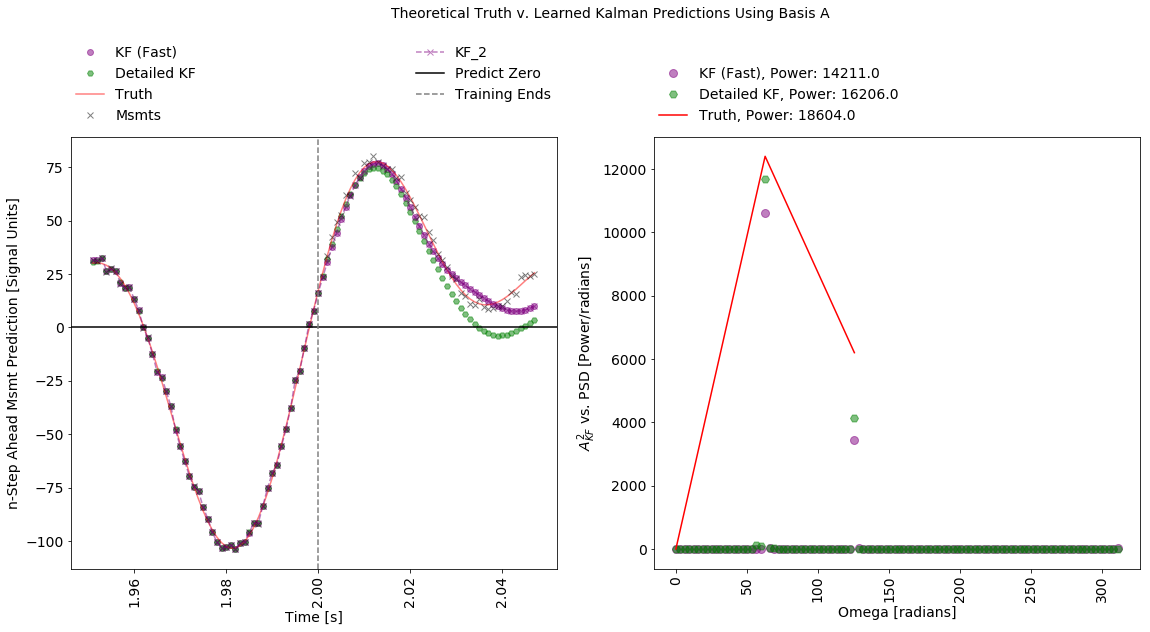

In [4]:
Test_Object.run_test_KF()

The purple and green lines should be equal and this is an unresolved errors. (Demo 1). 



Now the parameters I used were untuned. Let's generate lots of Kalman predictions and average over them

In [5]:
Test_Object.ensemble_avg_predictions()

What does this look like? 

The plot below will show log(MSE error) over "max_it" number of (truth, data) realisations, where a Kalman filter is applied to each realisation. This generates predictions and we compare MSE of predictions and the truth.

The black line presents predicting the mean of the random process (zero). All other trajectories have been normalised such that below black line = good, above black line = bad.

Don't worry about choice of basis and prediction methods, or the fact that MSE is calculated over 48 forecasting steps. 

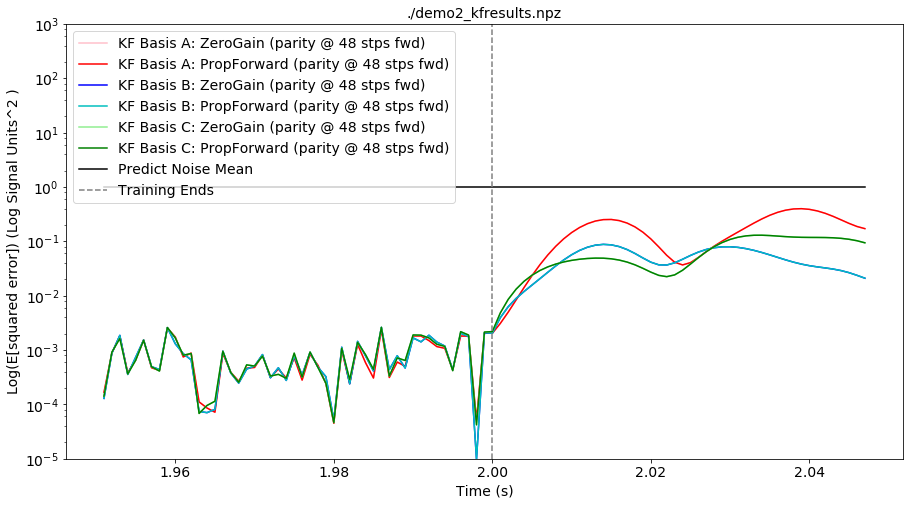

In [6]:
filename_and_path_KF = './'+str(Test_Object.filename_KF)+'.npz'
plotter_KF = Plot_KF_Results(exp_params_, filename_and_path_KF)
plotter_KF.make_plot()

What does one prediction in this ensemble look like?

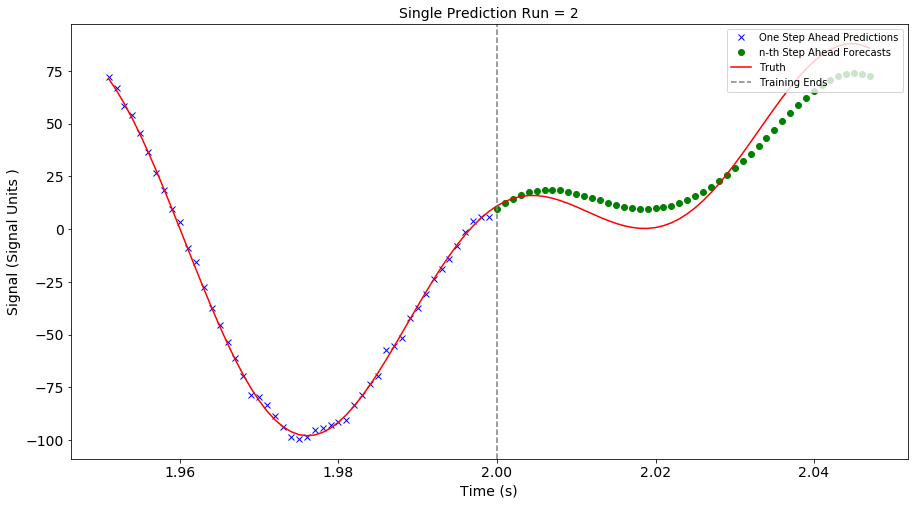

In [7]:
plotter_KF.show_one_prediction()

Now, here are the initial parameters I used:

In [8]:
print('sigma, R', Test_Object.optimal_sigma, Test_Object.optimal_R )

('sigma, R', 0.1, 0.1)


But after optimisation, I will find the pair which minimises the lowest prediction Bayes risk. Since we haven't done any optimisation yet, this will show "None".

In [9]:
'Lowest Loss Pair:', Test_Object.lowest_pred_BR_pair

('Lowest Loss Pair:', None)

Let's optimise. I call "Naive Implementation" because I am hoping that this entire chunk of code will be replaced by a nifty swift algorithm, or a fast parallel loop:

In [10]:
Test_Object.naive_implementation()

Time Taken for BR Map:  36.1633169651


What does this look like? Let's read the data and plot it:

Optimal params [  1.98648349e-05   6.50382797e+00] [  2.03099060e-05   2.90744776e-06]
Prediction
Loss Minimising Point Index: 7
Optimal Hyper Parameters:  [  1.98648349e-05   6.50382797e+00]
Loss Value 0.834728627127
Forecasting
Loss Minimising Point Index: 8
Optimal Hyper Parameters:  [  2.03099060e-05   2.90744776e-06]
Loss Value 0.0672407754548


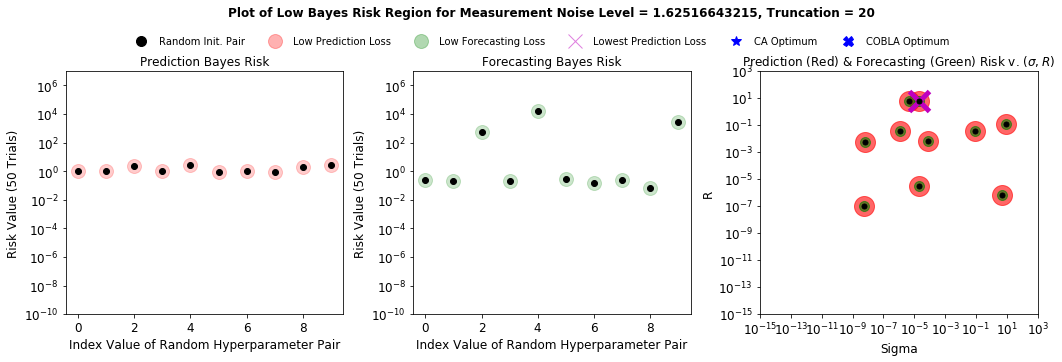

In [11]:
filename_and_path_BR = './'+str(Test_Object.filename_BR)+'.npz'
plotter_BR = Plot_BR_Results(filename_and_path_BR)
plotter_BR.make_plot()

The first plot is Prediction Risk , the second plot is Forecasting Risk. The x axis refers to an index which denotes a randomly generated (sigma, R) pair. The lowest loss values are highlighted by color balls. Overlap of red and green balls denotes that our optimisation problem makes sense (i.e. using prediction losses to tune the filter will also give us good forecasts).

The last plot is the lowest loss values in parameter space. The lowest loss values are high lighted with colored balls, and X marks the spot for the lowest Bayes Risk. 


So what is X?

In [12]:
Test_Object.get_tuned_params()

Optimal params fore prediction and forecasting [  1.98648349e-05   6.50382797e+00] [  1.13034225e-06   3.44004742e-02]


Note that my analysis will still be using the original parameters

In [13]:
print('sigma, R', Test_Object.optimal_sigma, Test_Object.optimal_R )

('sigma, R', 0.1, 0.1)


I can feed my lowest risk parameters...

In [14]:
'Lowest Loss Pair:', Test_Object.lowest_pred_BR_pair

('Lowest Loss Pair:', array([  1.98648349e-05,   6.50382797e+00]))

...to a Kalman function, like this:

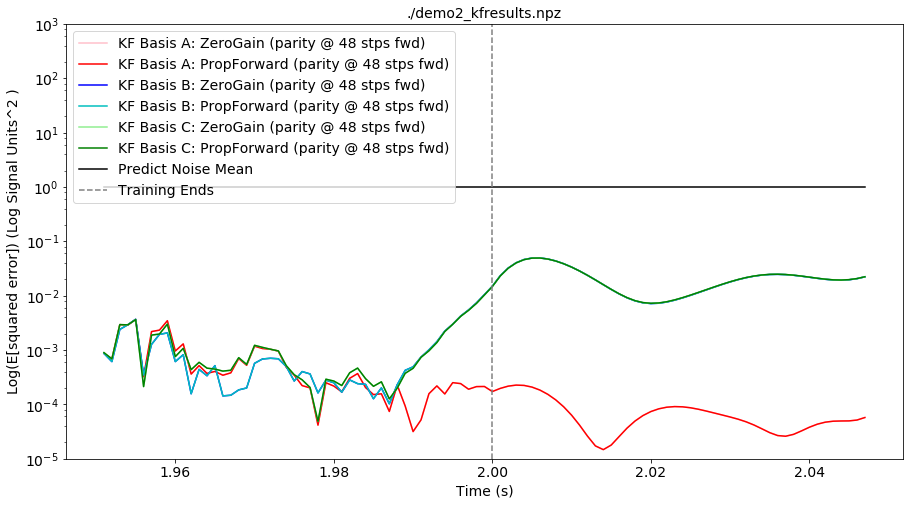

In [15]:
Test_Object.ensemble_avg_predictions(chosen_params=Test_Object.lowest_pred_BR_pair)
plotter_KF = Plot_KF_Results(exp_params_, filename_and_path_KF)
plotter_KF.make_plot()

But, in general, all functions will default to the untuned parameters. For example, calling ensemble averaging without the tuned parameters will give me a plot, that on average, looks like the un-tuned Kalman filter:

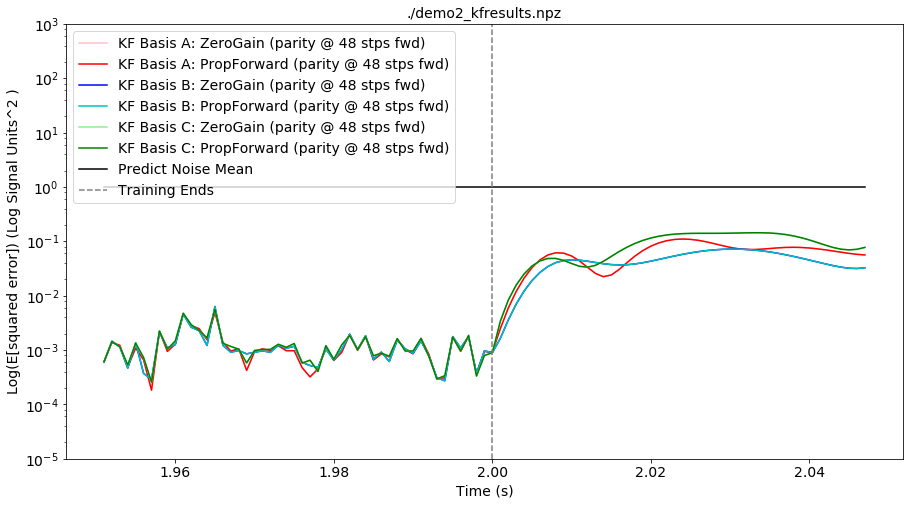

In [16]:
Test_Object.ensemble_avg_predictions()
plotter_KF = Plot_KF_Results(exp_params_, filename_and_path_KF)
plotter_KF.make_plot()

This is dumb. So  let me set the tuned parameters for all my analysis from now on:

In [17]:
Test_Object.set_tuned_params()

Did it work? Let me check what Sigma and R are:

In [18]:
print('sigma, R', Test_Object.optimal_sigma, Test_Object.optimal_R )

('sigma, R', 1.9864834928132401e-05, 6.5038279710585734)


This should be exactly the same as below:

In [19]:
'Lowest Loss Pair:', Test_Object.lowest_pred_BR_pair

('Lowest Loss Pair:', array([  1.98648349e-05,   6.50382797e+00]))

What does a tuned prediction look like?

Well, let's just run the KF test function again. Notice that this time, kf_fast.py and detailed_kf.py agree perfectly

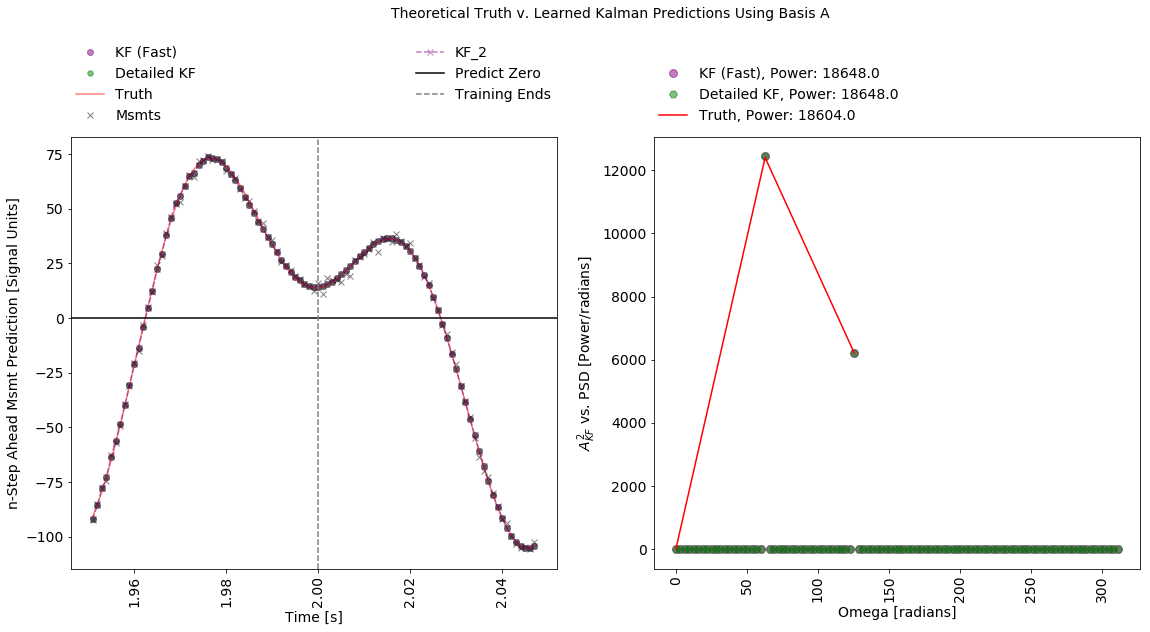

In [20]:
Test_Object.run_test_KF()

Just to close the loop, you can also redo some ensemble averaging and randomly pick a prediction out of that:

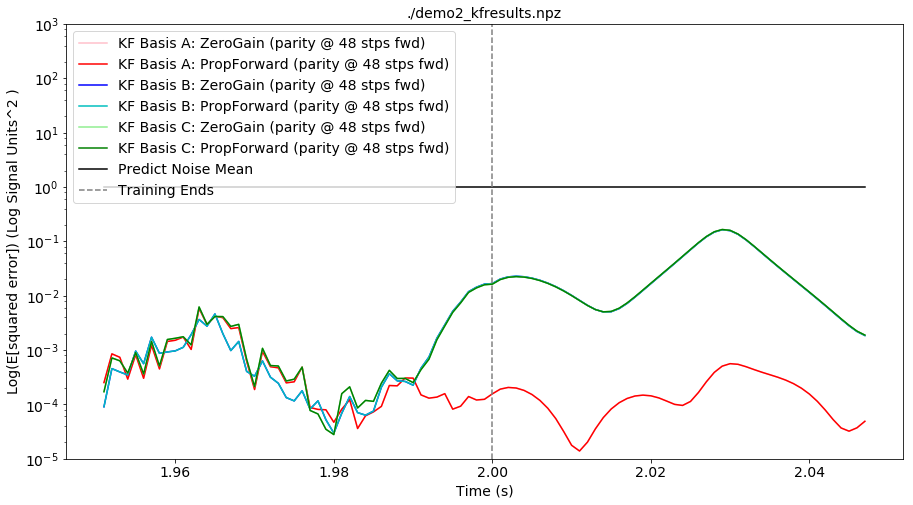

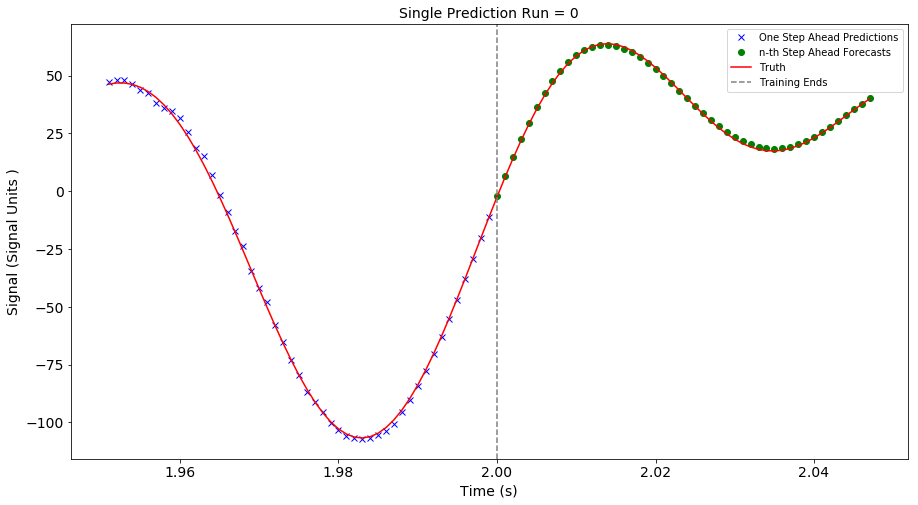

In [21]:
Test_Object.ensemble_avg_predictions()
plotter_KF = Plot_KF_Results(exp_params_, filename_and_path_KF)
plotter_KF.make_plot()
plotter_KF.show_one_prediction()

This is so boring.

Let's try 1/f shape with 40 tones spaced  1 Hz apart. (That's still boring.)

I will do 50 random choices of parameters and 50 iterations for each choice. On my loss map, I only want to highlight 10 lowest risk instances (instead of truncation = 20).  I'm going to load Test_Object3 and call this Demo 3

In [39]:
########################
# File Data
########################
filename0_2 = 'demo3'
savetopath_2 = './'

########################
# New Bayes Risk Parameters
########################
bayes_params_2 = [50, 50, space_size_, 10]

########################
# New Truth
########################
var_f0 = 1.0 #2.0*(4.0/3.0)*4.0*10**(-4)
var_J = 40 #int((1.0/2.0)*(3.0/4.0)*10**5)
var_p = -1
true_noise_params_2 = [apriori_f_mean_, pdf_type_u_, alpha_, var_f0, var_p, var_J, jstart_]

Let's load the object and do our basic check:

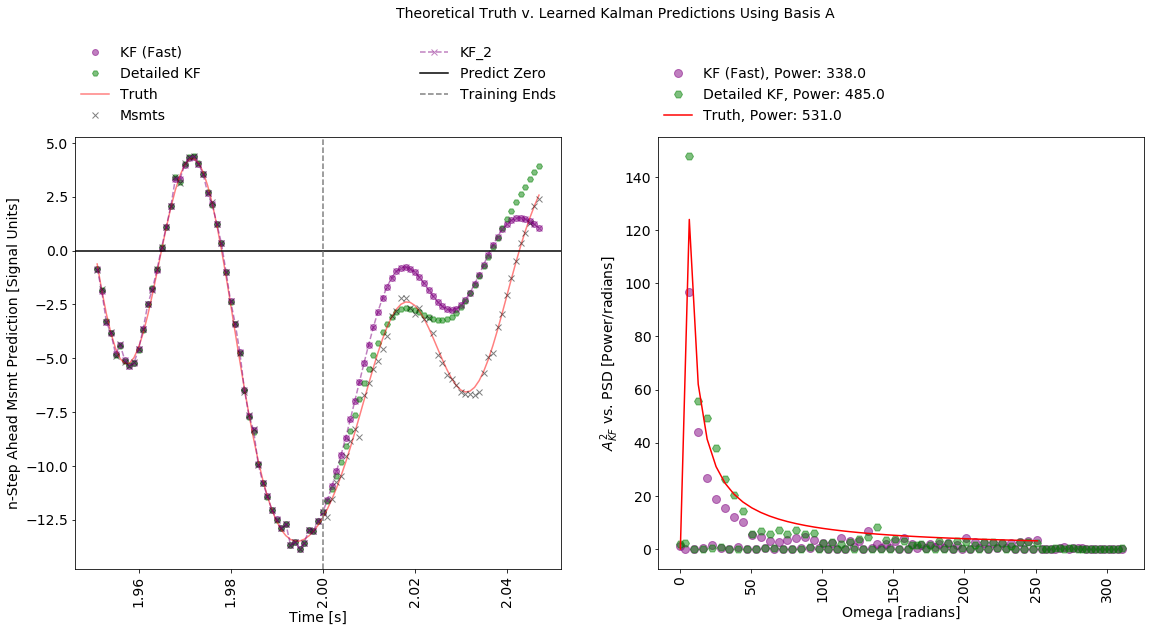

('My initial sigma, R =', 0.1, 0.1)


In [40]:
Test_Object3 = Create_KF_Experiment(bayes_params_2, filename0_2, savetopath_, max_it_, exp_params_, kalman_params_, 
                                    msmt_noise_params_, true_noise_params_2, 
                                    user_defined_variance=None, skip_msmts=skip)

Test_Object3.run_test_KF()
print('My initial sigma, R =', Test_Object3.optimal_sigma, Test_Object3.optimal_R)

Then let's optimise:

In [41]:
Test_Object3.naive_implementation()
Test_Object3.get_tuned_params()
Test_Object3.set_tuned_params()

Time Taken for BR Map:  5976.70039201
Optimal params fore prediction and forecasting [  6.64021358e-10   7.14725982e-06] [  6.53125007e-08   6.19757502e-08]


See the optimisation results:

Optimal params [  6.64021358e-10   7.14725982e-06] [  6.53125007e-08   6.19757502e-08]
Prediction
Loss Minimising Point Index: 4
Optimal Hyper Parameters:  [  6.64021358e-10   7.14725982e-06]
Loss Value 0.0303142116735
Forecasting
Loss Minimising Point Index: 16
Optimal Hyper Parameters:  [  6.53125007e-08   6.19757502e-08]
Loss Value 0.00632167916612


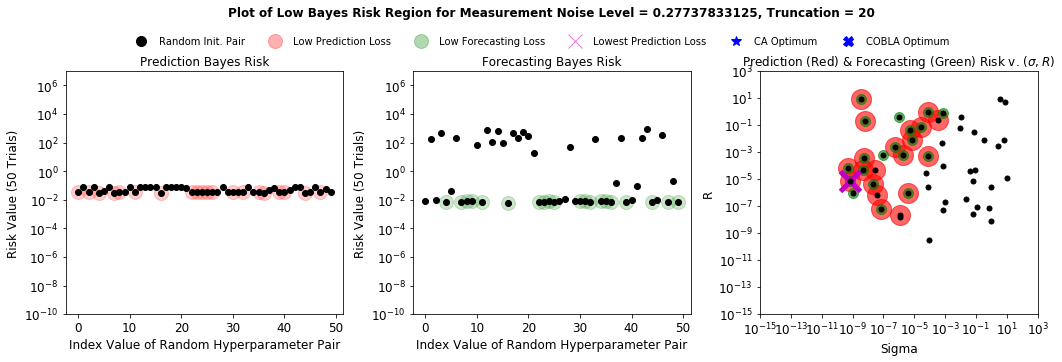

In [42]:
filename_and_path_BR_3 = './'+str(Test_Object3.filename_BR)+'.npz'
plotter_BR_3 = Plot_BR_Results(filename_and_path_BR_3)
plotter_BR_3.make_plot()

And, create all the cool data using a tuned filter:

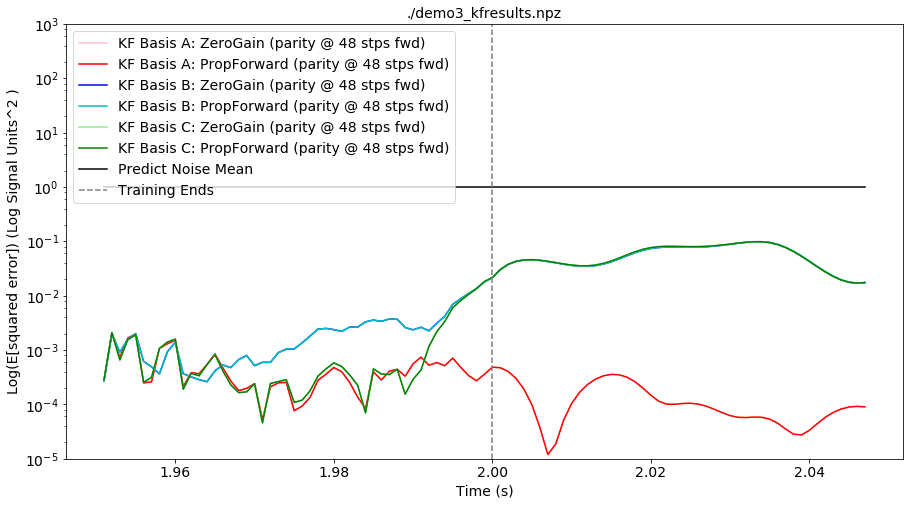

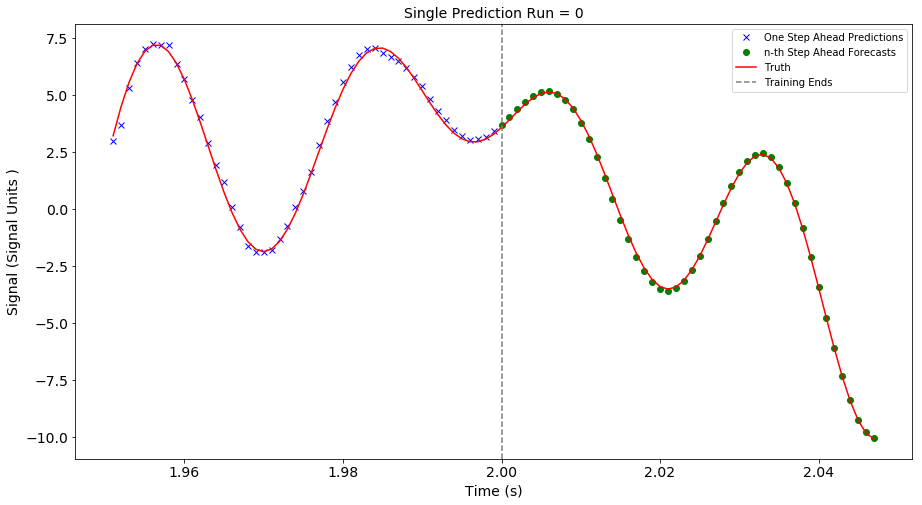

In [43]:
Test_Object3.ensemble_avg_predictions()
filename_and_path_KF_3 = './'+str(Test_Object3.filename_KF)+'.npz'
plotter_KF_3 = Plot_KF_Results(exp_params_, filename_and_path_KF_3)
plotter_KF_3.make_plot()
plotter_KF_3.show_one_prediction()